# Setting up the kaggle dataset to load (need to upload api key/json file)

In [ ]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install wandb -qqq

In [ ]:
from google.colab import files, drive
# files.upload()
!wandb login
drive.mount('/content/gdrive')
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
# !cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

wandb: Currently logged in as: varung2 (use `wandb login --relogin` to force relogin)
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-05 14:54:57           4377        430  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2520        243  0.9375           
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            593         27  1.0              
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes            

# Loading libraries

In [ ]:
import torch
from torch import nn
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

from google.colab import drive
import wandb

%load_ext tensorboard
torch.manual_seed(1)

# other packages
import re
import numpy as np
import glob, os, shutil
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from datetime import date
%matplotlib inline

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)

# for loading the tpu
enable_tpu = False
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    enable_tpu = True
except ImportError:
    pass

# set the device to use
device = None
if (enable_tpu):                
    device = xm.xla_device()
elif torch.cuda.is_available(): 
    device = torch.device("cuda:"+str(torch.cuda.current_device()))
    print("CUDA device name: {}".format(torch.cuda.get_device_name(torch.cuda.current_device())))
else:                           
    device = torch.device("cpu")

print("Using device: {}".format(device))

CUDA device name: Tesla K80
Using device: cuda:0


#Data Loading

In [ ]:
%%capture
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!mkdir covid19_radiography_data
!unzip covid19-radiography-database.zip -d covid19_radiography_data

In [ ]:
!mkdir -p /content/covid19_radiography_data/{test/{covid,normal},train/{covid,normal}}
!find /content/covid19_radiography_data/COVID-19_Radiography_Dataset/COVID/ -maxdepth 1 -type f | head -2500 | xargs cp -t /content/covid19_radiography_data/train/covid/
!find /content/covid19_radiography_data/COVID-19_Radiography_Dataset/Normal/ -maxdepth 1 -type f | head -2500 | xargs cp -t /content/covid19_radiography_data/train/normal/
!find /content/covid19_radiography_data/COVID-19_Radiography_Dataset/COVID/ -maxdepth 1 -type f | tail -2500 | xargs cp -t /content/covid19_radiography_data/test/covid/
!find /content/covid19_radiography_data/COVID-19_Radiography_Dataset/Normal/ -maxdepth 1 -type f | tail -2500 | xargs cp -t /content/covid19_radiography_data/test/normal/

In [ ]:
# implementing a custom transformer class to normalize images between -1 and 1
class xray_normalizer(object):
    def __call__(self, img):
        retimg = np.asarray(img)
        retimg = (retimg - np.min(retimg)) / np.max(retimg - np.min(retimg))
        return (retimg*2.0 - 1.0)
    def __repr__(self):
        return self.__class__.__name__+'()'
class cast_tensor(object):
    def __init__(self, dtype):
        self.dtype = dtype
    def __call__(self, img_tensor):
        return img_tensor.type(self.dtype)

In [ ]:
BATCH_SIZE = 8

In [ ]:
root = '/content/covid19_radiography_data/'
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize((150, 150)),
    xray_normalizer(),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(0, 1.0),
    cast_tensor(torch.FloatTensor)
])
image_dataset = torchvision.datasets.ImageFolder(root=os.path.join(root, 'train'), transform=data_transform)
loader = DataLoader(image_dataset, shuffle=True, batch_size=BATCH_SIZE)

Batch[0].class: Normal
Batch[0].shape: (150, 150)
Batch[41].class: Covid
Batch[41].shape: (150, 150)


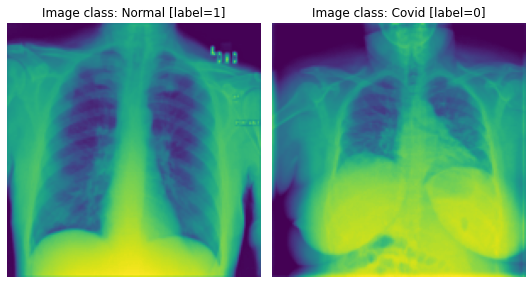

In [ ]:
def plot_sample_images(loader):
    fig, axes = plt.subplots(1, 2, figsize=(7.5,7.5))
    idx = 0

    # Showing an image example of each class
    printed_class = [False, False]
    class_name = ['Covid', 'Normal']
    for idx, (batchx, batchy) in enumerate(loader):
        img_classes = np.squeeze(batchy.numpy()).astype(int)
        batch_size = 1 if not img_classes.shape else img_classes.shape[0]
        np_img_batch = np.squeeze(batchx.numpy())
        iterable = zip([np_img_batch], [img_classes]) if not img_classes.shape else zip(np_img_batch, img_classes)
        for bidx, (img, label) in enumerate(iterable):
            if printed_class[label] is False:
                print('Batch[{}].class: {}'.format(idx+bidx*batch_size, class_name[label]))
                print('Batch[{}].shape: {}'.format(idx+bidx*batch_size, img.shape))
                pltimg = np.squeeze(img)
                axes[idx].set_title('Image class: {} [label={}]'.format(class_name[label], label))
                axes[idx].imshow(pltimg)
                axes[idx].axis('off')
                idx += 1
                printed_class[label] = True
                if (printed_class[0] is True) and (printed_class[1] is True):
                    plt.tight_layout()
                    plt.savefig('sample_data.png', bbox_inches='tight')
                    return

plot_sample_images(loader)

# Creating Conditional GAN model and Discriminator (according to paper)

*The generator network in this research consists of five transposed convolutional layers, four ReLU layers, four batch normalization layers, and Tanh Layer at the end of
the model, while the discriminator network consists of five convolutional layers, four leaky ReLU,
and three batch normalization layers. All the convolutional and transposed convolutional layers used
the same window size of 4x4 pixel with 64 filters for each layer.*

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_input_shape, num_classes, embedding_dim=50):
        super(Discriminator, self).__init__()
        # this is the normal image shape (i.e. h x w x c) - not the pytorch image input shape (c x w x h)
        self.input_shape = img_input_shape 
        self.embedding_path = nn.Sequential(*[
            nn.Embedding(num_embeddings=num_classes, embedding_dim=embedding_dim),
            nn.Linear(embedding_dim, img_input_shape[0]*img_input_shape[1]),
        ])

        self.conv_net = nn.Sequential(*[
            # first conv layer set (no batch)
            nn.Conv2d(img_input_shape[2]+1, 64, 4),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(64, 64, 4, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(64, 64, 4, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(64, 64, 4, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=False),

            nn.Conv2d(64, 64, 4),
            nn.LeakyReLU(inplace=False),
            # output dimension will be (1, 64, 32, 32)
        ])

        self.softmax_layer = nn.Sequential(*[
            nn.Flatten(),
            nn.Dropout(inplace=False),
            nn.Linear(64*13*13, 1),
            nn.Sigmoid()
        ])

    def forward(self, image, label):
        # print('DEBUG: image tensor device: {}'.format(image.device))
        # print('DEBUG: label tensor device: {}'.format(label.device))
        li_out = self.embedding_path(label)
        li_out = li_out.view(-1, 1, self.input_shape[0], self.input_shape[1])
        # print('DEBUG: li_out shape: {}'.format(li_out.shape))
        conv_in = torch.cat((image, li_out), dim=1)
        # print('DEBUG: conv in shape: {}'.format(conv_in.shape))
        conv_out = self.conv_net(conv_in)
        # print('DEBUG: conv out shape: {}'.format(conv_out.shape))
        result = self.softmax_layer(conv_out)
        # print('DEBUG: result out shape: {}'.format(result.shape))
        return result
        


class Generator(nn.Module):
    def __init__(self, input_width, num_classes, embedding_dim=50):
        super(Generator, self).__init__()
        latent_dimension = input_width
        self.embedding_path_output = 8
        self.latent_channels = input_width
        self.latent_dimension_output = self.latent_channels * (self.embedding_path_output**2)

        self.embedding_path = nn.Sequential(*[
            nn.Embedding(num_embeddings=num_classes, embedding_dim=embedding_dim),
            nn.Linear(embedding_dim, (self.embedding_path_output**2)),
        ]) 

        self.generator_input_path = nn.Sequential(*[
            nn.Linear(latent_dimension, self.latent_dimension_output),
            nn.ReLU(inplace=False),
        ])

        self.conv_net = nn.Sequential(*[
            # first transposed conv layer set
            nn.ConvTranspose2d(self.latent_channels+1, latent_dimension*8, 4, stride=2),
            nn.BatchNorm2d(latent_dimension*8),
            nn.ReLU(inplace=False),
            # 2nd conv layer set
            nn.ConvTranspose2d(latent_dimension*8, latent_dimension*4, 4, stride=2),
            nn.BatchNorm2d(latent_dimension*4),
            nn.ReLU(inplace=False),
            # 3rd conv layer set
            nn.ConvTranspose2d(latent_dimension*4, latent_dimension*2, 4, stride=2, padding=2),
            nn.BatchNorm2d(latent_dimension*2),
            nn.ReLU(inplace=False),
            # 4th conv layer set
            nn.ConvTranspose2d(latent_dimension*2, latent_dimension, 4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(latent_dimension),
            nn.ReLU(inplace=False),

            # 5th conv layer set
            nn.ConvTranspose2d(latent_dimension, 1, 4, stride=1, padding=1),
            nn.Tanh()
        ])


    def forward(self, z, label):
        # print('DEBUG: z tensor device: {}'.format(z.device))
        # print('DEBUG: label tensor device: {}'.format(label.device))
        li_out = self.embedding_path(label)
        gi_out = self.generator_input_path(z)
        # print('DEBUG: gi_out tensor shape: {}'.format(gi_out.shape))
        # print('DEBUG: li_out tensor shape: {}'.format(li_out.shape))
        gi_out = gi_out.view(-1, self.latent_channels, self.embedding_path_output, self.embedding_path_output)
        # print('DEBUG: gi_out tensor reshape: {}'.format(gi_out.shape))
        li_out = li_out.view(-1, 1, self.embedding_path_output, self.embedding_path_output)
        # print('DEBUG: li_out tensor reshape: {}'.format(li_out.shape))
        conv_in = torch.cat((gi_out, li_out), dim=1)
        # print('DEBUG: Convin shape: {}'.format(conv_in.shape))
        return self.conv_net(conv_in)

In [ ]:
def initialize_optimizer(model_parameters, option_dict):
    if option_dict['name'] == 'Adam':
        return torch.optim.Adam(params=model_parameters, lr=option_dict['lr'], betas=(option_dict['beta1'], option_dict['beta2']))
    elif option_dict['name'] == 'SGD':
        return torch.optim.SGD(params=model_parameters, lr=option_dict['lr'], momentum=option_dict['momentum'])
    else: # default optimizer
        option_dict['name'] = 'SGD'
        return torch.optim.SGD(params=model_parameters, lr=option_dict['lr'], momentum=option_dict['momentum'])
    # can add more options later


class Lung_CGAN():
    default_optim_dict = {
        'lr':0.01,
        'beta1':0.5,
        'beta2':0.999,
        'momentum':0.9,
        'name':'SGD',
        # can add more parameters for the optmizers as needed later
    }
    tensorboard_dir = 'tensorboard_dir'
    checkpoint_dir = '/content/chkpt_dir/'
    checkpoint_drive_dir = '/content/gdrive/MyDrive/chkpt_dir/'
    checkpoint_file_prefix = 'lung_cgan__'
    project_name = 'Lung_CGAN'

    def __init__(self, image_dimension, num_classes, noise_dimension=256, **kwargs):
        # some parameters
        self.noise_dim = noise_dimension
        self.num_classes = num_classes
        self.image_dimension = image_dimension
        self.emb_dim        = kwargs.get('embedding_dim', 50)
        self.device         = kwargs.get('device', 'cpu') # device default is cpu
        #enables storing and loading checkpoints from google drive 
        self.drive_chkpting = kwargs.get('en_drive_chkpting', False)

        # models and trackers
        self.generator = Generator(noise_dimension, num_classes, embedding_dim=self.emb_dim).to(device)
        self.discriminator = Discriminator(image_dimension, num_classes, embedding_dim=self.emb_dim).to(device)
        self.gen_loss_history = []
        self.disc_loss_history = []
        self.gen_optim = None
        self.disc_optim = None
        self.tb_writer_fake = None
        self.tb_writer_losses = None
        self.tb_writer_real = None
        self.current_epoch = None

        self.cosine_anneal_sched_D = None
        self.cosine_anneal_sched_G = None

    def training_loop(self, data_loader, epochs=1000, **kwargs):
        # custom options for the training loop
        chkpt_after_train       = kwargs.get('chkpt_after_train', True)
        train_from_latest_chkpt = kwargs.get('train_from_latest_chkpt', True)
        checkpt_directory       = kwargs.get('chkpt_dir', None)
        enable_tensorboard      = kwargs.get('enable_tensorboard', False)       # logs to tensorboard every summary steps
        enable_wandb            = kwargs.get('enable_wandb', True)
        summary_modulo          = kwargs.get('summary_n_steps', 5)              # writes to tensorboard every 5 training steps (by default)
        log_modulo              = kwargs.get('log_n_steps', 10)                 # logs to std output every 10 training steps (by default)
        verbose                 = kwargs.get('verbose', True)
        clear_losses            = kwargs.get('clear_accumulated_losses', True)  # clears the acumulated losses by default
        optimizer_option_dict   = kwargs.get('optimizer_option_dict', None)
        adversarial_loss        = kwargs.get('adversarial_loss', torch.nn.MSELoss())
        discriminator_modulo    = kwargs.get('train_discrim_n_steps', 10)
        download_checkpoints    = kwargs.get('download_checkpoints', False)
        
        # learning rates
        enable_disc_cosine_lr   = kwargs.get('enable_discrim_cosine_lr', True)
        disc_cosine_cycle_rate  = kwargs.get('discrim_cosine_cycle_rate', 20)
        enable_gen_cosine_lr    = kwargs.get('enable_generator_cosine_lr', False)
        gen_cosine_cycle_rate   = kwargs.get('generator_cosine_cycle_rate', 20)

        # wandb_run_postfix_name
        wandb_postfix_run_title = kwargs.get('wandb_postfix_run_title', None)

        
        ## Some options ammendment after parsing
        if checkpt_directory is None: 
            checkpt_directory = Lung_CGAN.checkpoint_drive_dir if self.drive_chkpting else Lung_CGAN.checkpoint_dir
        # merge the optimizer option dictionaries and create a set of parameters
        optimizer_option_dict   = (Lung_CGAN.default_optim_dict if optimizer_option_dict is None  
                                   else {**Lung_CGAN.default_optim_dict, **optimizer_option_dict})
        print('::: Using options for optmizer: {}'.format(optimizer_option_dict))
        print('::: Using adversarial loss: {}'.format(adversarial_loss))

        # load checkpoint before training (finds the oldest training checkpoint)
        loaded_from_checkpoint = False
        loaded_checkpoint_dict = None
        if train_from_latest_chkpt:
            if verbose: print('Checking for existing model checkpoint to train from...')
            checkpoint_list = []
            if os.path.exists(checkpt_directory):
                for file in os.listdir(checkpt_directory):
                    if file.endswith(".chkpt"): checkpoint_list.append(os.path.join(checkpt_directory, file))
            # print('DEBUG: checkpoint_list: {}'.format(checkpoint_list))
            # if there are checkpoints available
            if checkpoint_list:
                if verbose: print('Finding most recent checkpoint...')
                checkpoint_list.sort(key=lambda f: int(re.sub('\D', '', f)), reverse=True)
                file_base_name = os.path.splitext(os.path.basename(checkpoint_list[0]))[0]
                file_epoch = int(file_base_name.replace(Lung_CGAN.checkpoint_file_prefix, ''))
                # print('DEBUG: file_epoch: {}'.format(file_epoch))
                # print('DEBUG: self.current_epoch: {}'.format(self.current_epoch))
                # checks if the current trained epoch is the same as the file its loading from (to prevent redundant loading)
                if ((self.current_epoch is not None) and (self.current_epoch < file_epoch)) or (self.current_epoch is None):
                    self.current_epoch = file_epoch
                    print('::: Loading model from latest checkpoint: file path = "{}"'.format(checkpoint_list[0]))
                    loaded_checkpoint_dict = torch.load(checkpoint_list[0], map_location=self.device) # loads tensors onto gpu
                    self.generator.load_state_dict(loaded_checkpoint_dict['generator_model'])
                    self.discriminator.load_state_dict(loaded_checkpoint_dict['discriminator_model'])
                    
                    # get optimizer options and setup up optimizer from parameters
                    chkpt_optimizer_option_dict = loaded_checkpoint_dict['optimizer_options']
                    self.gen_optim = initialize_optimizer(self.generator.parameters(), chkpt_optimizer_option_dict)
                    self.disc_optim = initialize_optimizer(self.discriminator.parameters(), chkpt_optimizer_option_dict)

                    # load optimizer parameters
                    self.gen_optim.load_state_dict(loaded_checkpoint_dict['generator_optimizer'])
                    self.disc_optim.load_state_dict(loaded_checkpoint_dict['discriminator_optimizer'])
                    
                    # load the learning rate parameters (if applicable)
                    if loaded_checkpoint_dict['enable_discrim_cosine_lr']:
                        enable_disc_cosine_lr = True
                        disc_cosine_cycle_rate = loaded_checkpoint_dict['discrim_cosine_cycle_rate']
                        self.cosine_anneal_sched_D = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.disc_optim, loaded_checkpoint_dict['discrim_cosine_cycle_rate'])
                        self.cosine_anneal_sched_D.load_state_dict(loaded_checkpoint_dict['discrim_cosine_lr__state'])
                    if loaded_checkpoint_dict['enable_generator_cosine_lr']:
                        enable_gen_cosine_lr = True
                        gen_cosine_cycle_rate = loaded_checkpoint_dict['generator_cosine_cycle_rate']
                        self.cosine_anneal_sched_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.gen_optim, loaded_checkpoint_dict['generator_cosine_cycle_rate'])
                        self.cosine_anneal_sched_G.load_state_dict(loaded_checkpoint_dict['generator_cosine_lr__state'])

                    loaded_from_checkpoint = True
            elif verbose: print('Found no checkpoints.')

        # tracking losses and images
        tb_fixed_noise_vector = None
        tb_fixed_labels_vector = None
        tb_step_counter = 0
        tb_show_real_once_flag = True
        if enable_tensorboard:
            # clear tensorboard directory
            if os.path.exists(Lung_CGAN.tensorboard_dir) and os.path.isdir(Lung_CGAN.tensorboard_dir):
                # not quite working for me
                !rm -rf $Lung_CGAN.tensorboard_dir

            self.tb_writer_fake = SummaryWriter(os.path.join(Lung_CGAN.tensorboard_dir, 'Lung_CGAN/fake'))
            self.tb_writer_real = SummaryWriter(os.path.join(Lung_CGAN.tensorboard_dir, 'Lung_CGAN/real'))
            self.tb_writer_losses = SummaryWriter(os.path.join(Lung_CGAN.tensorboard_dir, 'Lung_CGAN/losses'))
        if enable_wandb:
            config_dict = {
                'architecture': 'Conditional DCGAN',
                'dataset': 'COVID-19_Radiography_Dataset - from Kaggle',
                'adversarial_loss' : str(adversarial_loss),
            }
            config_dict = {**config_dict, **optimizer_option_dict}
            # print('DEBUG: config dict after combination: {}'.format(config_dict))
            # return
            wandb.init(project = Lung_CGAN.project_name, config=config_dict)
            run_title = Lung_CGAN.checkpoint_file_prefix+'0' if self.current_epoch is None else Lung_CGAN.checkpoint_file_prefix + str(self.current_epoch)
            full_run_name = run_title if wandb_postfix_run_title is None else run_title+'__'+wandb_postfix_run_title
            wandb.run.name = full_run_name
            print('::: Initializing weights & biases run name: {}'.format(full_run_name))

        # generate the fixed tensorboard input vectors for seeing progress in generating images for the monitors
        if enable_wandb or enable_tensorboard:
            if tb_fixed_noise_vector is None:
                tb_fixed_noise_vector = torch.randn((BATCH_SIZE, self.noise_dim), device=self.device)
            if tb_fixed_labels_vector is None:
                temp1 = torch.ones(BATCH_SIZE//2, dtype=torch.int, device=self.device)
                temp2 = torch.zeros(BATCH_SIZE - BATCH_SIZE//2, dtype=torch.int, device=self.device)
                tb_fixed_labels_vector = torch.cat((temp1, temp2))

        # load optimizers if not already loaded
        if self.gen_optim is None: 
            self.gen_optim  = initialize_optimizer(self.generator.parameters(), optimizer_option_dict)
        if self.disc_optim is None: 
            self.disc_optim = initialize_optimizer(self.discriminator.parameters(), optimizer_option_dict)
        if self.cosine_anneal_sched_D is None and enable_disc_cosine_lr:
            self.cosine_anneal_sched_D = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.disc_optim, disc_cosine_cycle_rate)
        if self.cosine_anneal_sched_G is None and enable_gen_cosine_lr:
            self.cosine_anneal_sched_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.gen_optim, gen_cosine_cycle_rate)

        self.generator.train()
        self.discriminator.train()

        # clear accumulated losses
        if clear_losses: self.gen_loss_history.clear(); self.disc_loss_history.clear();

        # Training Loop 
        if verbose: print('Starting training...')
        data_loader_size = len(data_loader)
        for epoc in tqdm(range(epochs), desc='Epochs', position=0, leave=False):
            for step, (image_batch, label_batch) in enumerate(tqdm(data_loader, desc='Training Step', position=0, leave=False)):
                # adversarial ground truth (for discriminator)
                valid = Variable(torch.ones((BATCH_SIZE, 1), device=self.device)) # for the discrim training
                fake = Variable(torch.zeros((BATCH_SIZE, 1), device=self.device)) # for the gener training

                real_img_batch = Variable(image_batch.to(device))
                real_lbl_batch = Variable(label_batch.to(device))

                # -----------------
                #  Train Generator
                # -----------------
                self.gen_optim.zero_grad()
                # random sample of noise as generator input
                z = Variable(torch.normal(0, 1, (BATCH_SIZE, self.noise_dim), device=self.device))
                gen_labels = Variable(torch.randint(0, self.num_classes, (BATCH_SIZE,), device=self.device))
                # generate a batch of images
                gen_imgs = self.generator(z, gen_labels)
                # measure generator ability to fool discriminator
                validity = self.discriminator(gen_imgs, gen_labels)
                gen_loss = adversarial_loss(validity, valid)
                if (step % log_modulo == 0): self.gen_loss_history.append(gen_loss.detach())
                gen_loss.backward()
                self.gen_optim.step()
                if enable_gen_cosine_lr:
                    self.cosine_anneal_sched_G.step()
                
                if step % discriminator_modulo == 0:
                    # ---------------------
                    #  Train Discriminator
                    # ---------------------
                    self.disc_optim.zero_grad()
                    # loss for real images
                    validity_real = self.discriminator(real_img_batch, real_lbl_batch)
                    d_real_loss = adversarial_loss(validity_real, valid)
                    # loss for fake images
                    validity_fake = self.discriminator(gen_imgs.detach(), gen_labels)
                    d_fake_loss = adversarial_loss(validity_fake, fake)

                    # total loss
                    d_loss_total = (d_real_loss + d_fake_loss)/2
                    if (step % log_modulo == 0): self.disc_loss_history.append(d_loss_total.detach())
                    d_loss_total.backward()
                    self.disc_optim.step()
                    if enable_disc_cosine_lr:
                        self.cosine_anneal_sched_D.step()

                if verbose and (step % log_modulo == 0): 
                    print("Epoch: [{}], Batch: [{}], Generator Loss: [{}], Discriminator Loss: [{}]"
                    .format(epoc, step, self.gen_loss_history[-1], self.disc_loss_history[-1]))

                if enable_tensorboard and (step % summary_modulo == 0):
                    assert (self.tb_writer_fake is not None)
                    assert (self.tb_writer_real is not None)
                    self.tb_writer_losses.add_scalar('Loss/discriminator', d_loss_total.detach(), tb_step_counter)
                    self.tb_writer_losses.add_scalar('Loss/generator', gen_loss.detach(), tb_step_counter)
                    
                    with torch.no_grad():
                        assert (tb_fixed_noise_vector is not None)
                        assert (tb_fixed_labels_vector is not None)
                        self.generator.eval()
                        fake_imgs = self.generator(tb_fixed_noise_vector, tb_fixed_labels_vector).reshape(-1, *self.image_dimension[::-1]) 
                        igrid_fake = torchvision.utils.make_grid(fake_imgs, normalize=True)
                        self.tb_writer_fake.add_image('Lung fake image(s)', igrid_fake, global_step=tb_step_counter)

                        if tb_show_real_once_flag: # show the real images once as a preview
                            real_imgs = image_batch.reshape(-1, *self.image_dimension[::-1]) # need to get dims s.t. shape(b, c, h, w)
                            igrid_real = torchvision.utils.make_grid(real_imgs, normalize=True)
                            self.tb_writer_real.add_image('Lung real image(s)', igrid_real, global_step=0)
                            tb_show_real_once_flag = False

                        tb_step_counter += 1
                        self.generator.train()
                if enable_wandb and (step % summary_modulo == 0):
                    wandb.log({'discriminator loss': d_loss_total})
                    wandb.log({'generator loss': gen_loss})

                    with torch.no_grad():
                        assert (tb_fixed_noise_vector is not None)
                        assert (tb_fixed_labels_vector is not None)
                        self.generator.eval()
                        fake_imgs = self.generator(tb_fixed_noise_vector, tb_fixed_labels_vector).reshape(-1, *self.image_dimension[::-1])
                        wandb.log({'Lung fake image(s)': [wandb.Image(i) for i in fake_imgs]})
                        if tb_show_real_once_flag: # show the real images once as a preview
                            real_imgs = image_batch.reshape(-1, *self.image_dimension[::-1]) # need to get dims s.t. shape(b, c, h, w)
                            wandb.log({'Lung real image(s)' : [wandb.Image(i) for i in real_imgs]})
                            tb_show_real_once_flag = False
                        self.generator.train()

        # after training 
        if enable_tensorboard:
            self.tb_writer_fake.close()
            self.tb_writer_real.close()
        if enable_wandb:
            wandb.finish()
        
        self.generator.eval()
        if verbose: print('Finished Training.')
        self.current_epoch = epochs if self.current_epoch is None else self.current_epoch + epochs

        # save checkpoint if applicable
        if chkpt_after_train:
            torch_chkpt_file_path = os.path.join(checkpt_directory, Lung_CGAN.checkpoint_file_prefix + str(self.current_epoch) + '.chkpt')
            if verbose: print('Saving model checkpoint... file path = "{}"'.format(torch_chkpt_file_path))
            
            # saving model parameters
            torch_chkpt_dict = {}
            torch_chkpt_dict['generator_model'] = self.generator.state_dict()
            torch_chkpt_dict['discriminator_model'] = self.discriminator.state_dict()
            torch_chkpt_dict['generator_optimizer'] = self.gen_optim.state_dict()
            torch_chkpt_dict['discriminator_optimizer'] = self.disc_optim.state_dict()

            # load the learning rate parameters (if applicable)
            torch_chkpt_dict['enable_discrim_cosine_lr'] = enable_disc_cosine_lr
            if enable_disc_cosine_lr:
                torch_chkpt_dict['discrim_cosine_cycle_rate'] = disc_cosine_cycle_rate
                torch_chkpt_dict['discrim_cosine_lr__state'] = self.cosine_anneal_sched_D.state_dict()
            torch_chkpt_dict['enable_generator_cosine_lr'] = enable_gen_cosine_lr
            if enable_gen_cosine_lr:
                torch_chkpt_dict['generator_cosine_cycle_rate'] = gen_cosine_cycle_rate
                torch_chkpt_dict['generator_cosine_lr__state'] = self.cosine_anneal_sched_G.state_dict()

            # saving optimizer options (for reinitialization later)
            if loaded_from_checkpoint:
                assert (loaded_checkpoint_dict is not None)
                torch_chkpt_dict['optimizer_options'] = loaded_checkpoint_dict['optimizer_options']
            else:
                torch_chkpt_dict['optimizer_options'] = optimizer_option_dict
            
            Path(checkpt_directory).mkdir(parents=True, exist_ok=True)
            torch.save(torch_chkpt_dict, torch_chkpt_file_path)
            if download_checkpoints: files.download(torch_chkpt_file_path) 
        if verbose: print('Done!')


    def load_from_checkpoint(self, file_path=None, checkpt_directory=None, verbose=True):
        if checkpt_directory is None: 
            checkpt_directory = Lung_CGAN.checkpoint_drive_dir if self.drive_chkpting else Lung_CGAN.checkpoint_dir
        if file_path is None:
            if verbose: print('Checking for existing model checkpoint to train from...')
            checkpoint_list = []
            if os.path.exists(checkpt_directory):
                for file in os.listdir(checkpt_directory):
                    if file.endswith(".chkpt"): checkpoint_list.append(os.path.join(checkpt_directory, file))
            # if there are checkpoints available
            if checkpoint_list:
                if verbose: print('Finding most recent checkpoint...')
                checkpoint_list.sort(key=lambda f: int(re.sub('\D', '', f)), reverse=True)
                file_path = checkpoint_list[0];
            else:
                print('Unable to load checkpoint.')
                return
        
        if os.path.exists(file_path) and os.path.isfile(file_path):
            file_base_name = os.path.splitext(os.path.basename(file_path))[0]
            file_epoch = int(file_base_name.replace(Lung_CGAN.checkpoint_file_prefix, ''))
            
            # checks if the current trained epoch is the same as the file its loading from (to prevent redundant loading)
            if ((self.current_epoch is not None) and (self.current_epoch < file_epoch)) or (self.current_epoch is None):
                self.current_epoch = file_epoch
                if verbose: print('Loading model from latest checkpoint: file path = "{}"'.format(file_path))
                loaded_checkpoint_dict = torch.load(file_path, map_location=self.device) # loads tensors onto gpu
                self.generator.load_state_dict(loaded_checkpoint_dict['generator_model'])
                self.discriminator.load_state_dict(loaded_checkpoint_dict['discriminator_model'])
                
                # get optimizer options and setup up optimizer from parameters
                chkpt_optimizer_option_dict = loaded_checkpoint_dict['optimizer_options']
                self.gen_optim = initialize_optimizer(self.generator.parameters(), chkpt_optimizer_option_dict)
                self.disc_optim = initialize_optimizer(self.discriminator.parameters(), chkpt_optimizer_option_dict)

                # load optimizer parameters
                self.gen_optim.load_state_dict(loaded_checkpoint_dict['generator_optimizer'])
                self.disc_optim.load_state_dict(loaded_checkpoint_dict['discriminator_optimizer'])

                # load the learning rate parameters (if applicable)
                if loaded_checkpoint_dict['enable_discrim_cosine_lr']:
                    enable_disc_cosine_lr = True
                    disc_cosine_cycle_rate = loaded_checkpoint_dict['discrim_cosine_cycle_rate']
                    self.cosine_anneal_sched_D = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.disc_optim, loaded_checkpoint_dict['discrim_cosine_cycle_rate'])
                    self.cosine_anneal_sched_D.load_state_dict(loaded_checkpoint_dict['discrim_cosine_lr__state'])
                if loaded_checkpoint_dict['enable_generator_cosine_lr']:
                    enable_gen_cosine_lr = True
                    gen_cosine_cycle_rate = loaded_checkpoint_dict['generator_cosine_cycle_rate']
                    self.cosine_anneal_sched_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.gen_optim, loaded_checkpoint_dict['generator_cosine_cycle_rate'])
                    self.cosine_anneal_sched_G.load_state_dict(loaded_checkpoint_dict['generator_cosine_lr__state'])

        elif verbose: print('Could not find file: "{}"'.format(file_path))

    def generate_random_image(self, label, num_images=1):
        self.generator.eval()
        with torch.no_grad():
            latent_noise = torch.randn((num_images, self.noise_dim), device=self.device)
            gen_labels = torch.ones(num_images, dtype=torch.int, device=self.device)*label
            fake_imgs = self.generator(latent_noise, gen_labels).reshape(-1, *self.image_dimension[::-1])
            ret = (torch.squeeze(fake_imgs).detach().cpu().numpy())
            del latent_noise
            del gen_labels
        return ret.reshape(-1, self.image_dimension[0], self.image_dimension[1])

# Training model

In [ ]:
def train_gan_incrementally():
    curr_date = date.today()
    
    # initialization options (change as you see fit - and recall function)
    enable_drive_checkpointing = True
    
    # training options (change as you see fit - and recall function)
    num_epochs = 20 # approx 1 min per epoch with batchsize = 4
    num_loops = 5
    verbose = False
    summary_n_steps = 5
    enable_wandb = True
    wandb_postfix_run_title = curr_date.strftime("%m_%d_%y")
    enable_discrim_cosine_lr = False

    # optimizer options (change as you see fit - and recall function)
    optimizer_option_dict = {'lr':0.0002, 'name':'Adam', 'beta1':0.5, 'beta2':0.999}
    adversarial_loss = torch.nn.BCELoss()
    discriminator_modulo = 15
    
    # ------------------------------------------------------
    if enable_drive_checkpointing: drive.mount('/content/gdrive')

    # initialize gan
    gan = Lung_CGAN((150, 150, 1), 2, noise_dimension=128, 
                    device=device, 
                    en_drive_chkpting=enable_drive_checkpointing
                    )
    
    for i in tqdm(range(num_loops)):
        # gain training loop
        gan.training_loop(loader, 
                        epochs = num_epochs, 
                        summary_n_steps = summary_n_steps, 
                        verbose = verbose, 
                        optimizer_option_dict = optimizer_option_dict, 
                        adversarial_loss = adversarial_loss, 
                        train_discrim_n_steps = discriminator_modulo,
                        enable_wandb = enable_wandb,
                        wandb_postfix_run_title = wandb_postfix_run_title,
                        enable_discrim_cosine_lr = enable_discrim_cosine_lr,
        )

In [ ]:
train_gan_incrementally()

# Generating images for data augmentation

In [ ]:
# del gan
torch.cuda.empty_cache()
!nvidia-smi

Thu May  6 17:47:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    63W / 149W |   6312MiB / 11441MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# run once
gan = Lung_CGAN((150, 150, 1), 2, noise_dimension=128, 
                    device=device, 
                    en_drive_chkpting=True
                    )

gan.load_from_checkpoint()

from PIL import Image
from pathlib import Path

!mkdir /content/gdrive/MyDrive/generated_images/
!mkdir /content/gdrive/MyDrive/generated_images/normal
!mkdir /content/gdrive/MyDrive/generated_images/covid

path = '/content/gdrive/MyDrive/generated_images/'
Path(os.path.join(path, '/normal')).mkdir(parents=True, exist_ok=True)
Path(os.path.join(path, '/covid')).mkdir(parents=True, exist_ok=True)
# change these indices as needed
normal_images_idx_start = 0
covid_images_idx_start = 0

Checking for existing model checkpoint to train from...
Finding most recent checkpoint...
Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__740.chkpt"
mkdir: cannot create directory ‘/content/gdrive/MyDrive/generated_images/’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/generated_images/normal’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/generated_images/covid’: File exists


In [ ]:
normal_images = gan.generate_random_image(1, 100)
covid_images = gan.generate_random_image(0, 100)

fpath = os.path.join(path, 'normal/')
for idx, img in enumerate(normal_images):
    fname = '{}.png'.format(idx+normal_images_idx_start)
    plt.imsave(fpath+fname, img)
normal_images_idx_start += normal_images.shape[0]

fpath = os.path.join(path, 'covid/')
for idx, img in enumerate(covid_images):
    fname = '{}.png'.format(idx+covid_images_idx_start)
    plt.imsave(fpath+fname, img)
covid_images_idx_start += covid_images.shape[0]

print('DEBUG: AFTER SAVING: normal images idx start: {}'.format(normal_images_idx_start))
print('DEBUG: AFTER SAVING: covid images idx start: {}'.format(covid_images_idx_start))

DEBUG: AFTER SAVING: normal images idx start: 1000
DEBUG: AFTER SAVING: covid images idx start: 1000


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7.5,7.5))
axes[0].set_title('Image class: {} [label={}]'.format('Normal', 1))
axes[0].imshow(normal_images[0])
axes[0].axis('off')
axes[1].set_title('Image class: {} [label={}]'.format('Covid', 0))
axes[1].imshow(covid_images[1])
axes[1].axis('off')
plt.tight_layout()

# Some initial data collection on GAN training progress

In [ ]:
def data_collection(epoch_counts, save_path=None):
    gan = Lung_CGAN((150, 150, 1), 2, noise_dimension=128, device=device)
    root_chkpt_path = Lung_CGAN.checkpoint_drive_dir
    chkpts_to_graph = [os.path.join(root_chkpt_path, Lung_CGAN.checkpoint_file_prefix+str(epoch)+'.chkpt') for epoch in epoch_counts]

    # collect the set of images
    image_set = []
    for chkpt in chkpts_to_graph:
        gan.load_from_checkpoint(chkpt)
        image_set.append(gan.generate_random_image(0, num_images=1)[np.newaxis, ...])
    image_set = np.concatenate(image_set, axis=0)
    # print('DEBUG: image_set shape: {}'.format(image_set.shape))
    
    fig, ax = plt.subplots(image_set.shape[1], image_set.shape[0], figsize=(17.5, 17.5))
    for y, row in enumerate(ax):
        # for x, col in enumerate(row):
        row.imshow(image_set[y, 0, ...], cmap='gray')
        row.set_title('Epoch '+str(epoch_counts[y]))
        row.axis('off')
    plt.tight_layout()
    if save_path is not None: plt.savefig(save_path)
    plt.show()

Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__100.chkpt"
Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__200.chkpt"
Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__300.chkpt"
Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__400.chkpt"
Loading model from latest checkpoint: file path = "/content/gdrive/MyDrive/chkpt_dir/lung_cgan__500.chkpt"


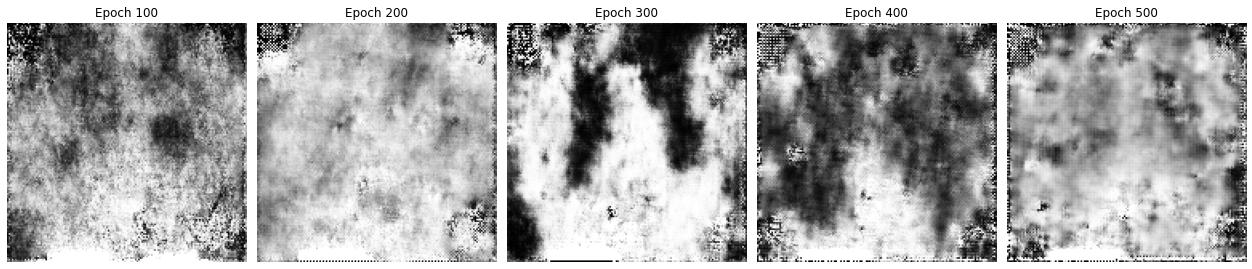

In [ ]:
data_collection([100, 200, 300, 400, 500], '/content/gan_image_evolution.png')

# Debugging cells

In [ ]:
# ## DEBUGGING TO GET THE OUTPUT SHAPE CORRECT
# gen = Generator(input_width=256, num_classes=2)
# gen.train()
# latent_vector = torch.rand(256)
# result = gen(latent_vector, torch.from_numpy(np.array([1])))
# print('DEBUG: generator output shape: {}'.format(result.shape))

# ## DEBUGGING DISCRIMINATOR TO GET OUTPUT SHAPE
# disc = Discriminator((300, 300, 1), 2)
# disc.train()

# result = disc(result, torch.from_numpy(np.array([1])))
# print('DEBUG: discriminator output shape: {}'.format(result.shape))
# print('Generator model summary:\n{}'.format(gen))
# print('Discriminator model summary:\n{}'.format(disc))

In [ ]:
## DEBUGGING TO GET THE OUTPUT SHAPE CORRECT
testin = torch.rand((1, 129, 8, 8))
first_layer = nn.Sequential(*[
    nn.ConvTranspose2d(129, 128*8, 4, stride=2),
    nn.BatchNorm2d(128*8),
    nn.LeakyReLU(inplace=True),
])
out = first_layer(testin)
print('DEBUG: out.shape: {}'.format(out.shape))

second_layer = nn.Sequential(*[
    nn.ConvTranspose2d(128*8, 128*4, 4, stride=2),
    nn.BatchNorm2d(128*4),
    nn.LeakyReLU(inplace=True),
])

out = second_layer(out)
print('DEBUG: out.shape: {}'.format(out.shape))


third_layer = nn.Sequential(*[
    nn.ConvTranspose2d(128*4, 128*2, 4, stride=2, padding=2),
    nn.BatchNorm2d(128*2),
    nn.LeakyReLU(inplace=True),
])

out = third_layer(out)
print('DEBUG: out.shape: {}'.format(out.shape))

fourth_layer = nn.Sequential(*[
    nn.ConvTranspose2d(128*2, 128, 4, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(inplace=True),
])

out = fourth_layer(out)
print('DEBUG: out.shape: {}'.format(out.shape))

final_layer = nn.Sequential(*[
    nn.ConvTranspose2d(128, 1, 4, stride=1, padding=1),
    nn.Tanh()
])

out = final_layer(out)
print('DEBUG: out.shape: {}'.format(out.shape))

DEBUG: out.shape: torch.Size([1, 1024, 18, 18])
DEBUG: out.shape: torch.Size([1, 512, 38, 38])
DEBUG: out.shape: torch.Size([1, 256, 74, 74])
DEBUG: out.shape: torch.Size([1, 128, 149, 149])
DEBUG: out.shape: torch.Size([1, 1, 150, 150])


In [ ]:
# %tensorboard --logdir $Lung_CGAN.tensorboard_dir

In [ ]:
# call this to clear the tensorboard data
# !rm -rf $Lung_CGAN.tensorboard_dir